In [1]:
import pickle
from quests_data import *

from ase import Atoms
from ase.io import read, write
from quests.tools.plotting import savefig, COLORS
from matscipy.neighbours import neighbour_list
import lammps_logfile as lmp
from scipy.optimize import curve_fit

import networkx as nx

ROOT_DIR = "../data/05-Cu"

## CNT analysis from a-CNA

In [2]:
traj = read(f"{ROOT_DIR}/cna-clean.xyz", index=":")

### Total number of FCC-like sites

In [3]:
num_fcc = np.array([
    np.sum(at.arrays["structure_type"] == 1)
    for at in traj
])

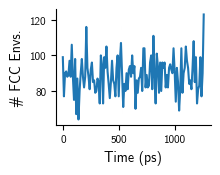

In [4]:
fig, ax = plt.subplots(figsize=(2, 1.5))

n = np.arange(0, len(num_fcc)) * 10

ax.plot(n, num_fcc)

ax.set_xlabel("Time (ps)")
ax.set_ylabel("# FCC Envs.")

# savefig(fig, "05-cnt-acna_count.pdf")
plt.show()

### Nuclei analysis

In [5]:
def get_cnt(atoms, threshold=-0.5, cutoff=3.0, k=2):
    nbrs_i, nbrs_j = neighbour_list("ij", atoms=atoms, cutoff=cutoff)

    stype = atoms.arrays["structure_type"]
    idx = stype == 1
    nbrs_idx = idx[nbrs_i] & idx[nbrs_j]

    G = nx.Graph()
    for i, j in zip(nbrs_i[nbrs_idx], nbrs_j[nbrs_idx]):
        G.add_edge(i, j)
    
    nodes = []
    for subg in nx.connected_components(G):
        sg = G.subgraph(subg)
        for parts in nx.k_edge_components(sg, k=k):
            nodes.append(len(parts))
    nodes = np.array(nodes)
    
    return nodes

In [6]:
cnt = {}
for frame in tqdm.tqdm(range(127)):
    n = get_cnt(traj[frame], threshold=0)
    cnt[frame] = n

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:49<00:00,  2.55it/s]


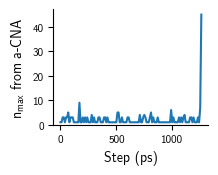

In [7]:
frames = np.arange(127)
max_n = np.array([n.max() for n in cnt.values()])

fig, ax = plt.subplots(figsize=(2, 1.5))

ax.plot(frames * 10, max_n)

ax.set_ylim(0)
ax.set_ylabel("n$_{max}$ from a-CNA")
ax.set_xlabel("Step (ps)")

# savefig(fig, "05-cnt-cna_maxn.pdf")
plt.show()

### Size distribution

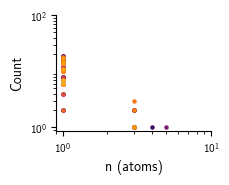

In [8]:
fig, ax = plt.subplots(figsize=(2, 1.5))

norm = plt.Normalize(0, 150)
cmap = lambda x: cm.inferno(norm(x))

for i in range(0, 126, 2):
    n = cnt[i]

    size = np.arange(np.max(n) + 1)
    dist = np.bincount(n)

    mask = dist > 0
    ax.scatter(size[mask], dist[mask], color=cmap(i), s=5)
    
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("n (atoms)")
ax.set_ylabel("Count")

ax.set_yticks([1e0, 1e2])
ax.set_xlim([0.9, 10])
# savefig(fig, "05-cnt-cna_dist.pdf")
# fig.tight_layout()
plt.show()